In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

## Configuration and Spark connection

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

spark = SparkSession.builder \
    .master("local") \
    .appName("churn_modelling") \
    .config("spark.executer.memory", "16gb") \
    .getOrCreate()



sc = spark.sparkContext
sc

<SparkContext master=local appName=churn_modelling>

## Basic DF operations

In [4]:
spark_df = spark.read.csv("churn.csv",
                           header = True,
                           inferSchema = True,
                           sep = ","
                           )
spark_df.cache()

DataFrame[_c0: int, Names: string, Age: double, Total_Purchase: double, Account_Manager: int, Years: double, Num_Sites: double, Churn: int]

In [5]:
spark_df.show(5)

+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|  2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|  3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|  4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 5 rows



In [6]:
spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [ ]:
## rearranging indexes

In [7]:
spark_df = spark_df.withColumnRenamed("_c0","index")
spark_df.show(5)

+-----+----------------+----+--------------+---------------+-----+---------+-----+
|index|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|    2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|    3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|    4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 5 rows



In [8]:
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])
spark_df.show(5)

+-----+----------------+----+--------------+---------------+-----+---------+-----+
|index|           names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|    2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|    3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|    4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 5 rows



In [ ]:
## checking unique and null rows

In [9]:
spark_df.count()

900

In [10]:
len(spark_df.columns)

8

In [11]:
spark_df.select("names").distinct().count()

899

In [12]:
distinct_check_df = spark_df.groupby("names")
distinct_check_df.count().sort("count", ascending=False).show(5)

+----------------+-----+
|           names|count|
+----------------+-----+
|   Jennifer Wood|    2|
|    Patrick Bell|    1|
|   Chelsea Marsh|    1|
|Patrick Robinson|    1|
|     John Barber|    1|
+----------------+-----+
only showing top 5 rows



In [13]:
spark_df.filter(spark_df.names=="Jennifer Wood").show()

+-----+-------------+----+--------------+---------------+-----+---------+-----+
|index|        names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|   22|Jennifer Wood|35.0|       9381.12|              1| 6.78|     11.0|    1|
|  439|Jennifer Wood|48.0|      11585.16|              0| 4.61|      9.0|    0|
+-----+-------------+----+--------------+---------------+-----+---------+-----+



In [14]:
distinct_df = spark_df.select("names").dropDuplicates().groupby("names").count().sort("count", ascending=False)
distinct_df.groupby("names").count().sort("count", ascending=False).show(3)

+----------------+-----+
|           names|count|
+----------------+-----+
|    Patrick Bell|    1|
|Patrick Robinson|    1|
|   Chelsea Marsh|    1|
+----------------+-----+
only showing top 3 rows



In [15]:
distinct_df.select("names").count()

899

## Exploratory Data Analysis

In [16]:
spark_df.select("age","total_purchase", "account_manager", "years","num_sites","churn").describe().toPandas().transpose()

0                    1                   2      3  \
summary          count                 mean              stddev    min   
age                900    41.81666666666667   6.127560416916251   22.0   
total_purchase     900    10062.82403333334   2408.644531858096  100.0   
account_manager    900   0.4811111111111111  0.4999208935073339      0   
years              900     5.27315555555555   1.274449013194616    1.0   
num_sites          900    8.587777777777777  1.7648355920350969    3.0   
churn              900  0.16666666666666666  0.3728852122772358      0   

                        4  
summary               max  
age                  65.0  
total_purchase   18026.01  
account_manager         1  
years                9.15  
num_sites            14.0  
churn                   1

In [17]:
spark_df.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|  150|
|    0|  750|
+-----+-----+



In [18]:
kor_data = spark_df.drop("index","names").toPandas()
kor_data

age  total_purchase  account_manager  years  num_sites  churn
0    42.0        11066.80                0   7.22        8.0      1
1    41.0        11916.22                0   6.50       11.0      1
2    38.0        12884.75                0   6.67       12.0      1
3    42.0         8010.76                0   6.71       10.0      1
4    37.0         9191.58                0   5.56        9.0      1
..    ...             ...              ...    ...        ...    ...
895  42.0        12800.82                1   3.62        8.0      0
896  52.0         9893.92                0   6.91        7.0      0
897  45.0        12056.18                0   5.46        4.0      0
898  51.0         6517.93                1   5.47       10.0      0
899  39.0         9315.60                1   5.02       10.0      0

[900 rows x 6 columns]

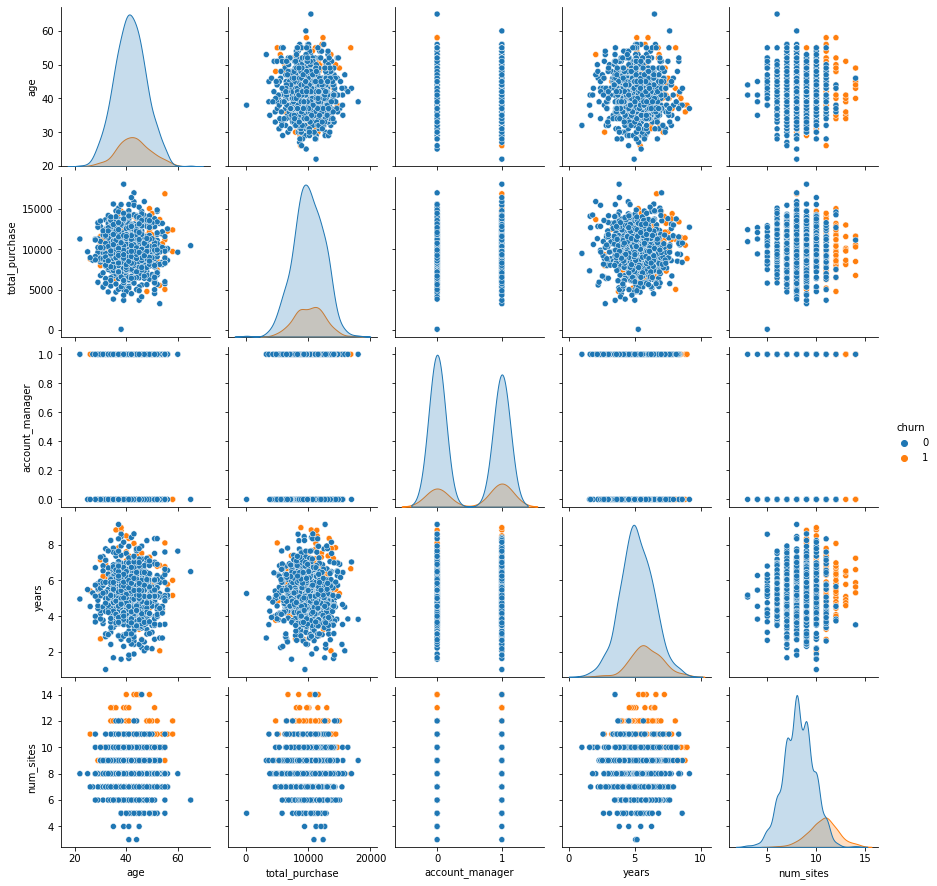

In [19]:
import seaborn as sns
sns.pairplot(kor_data, hue = "churn");

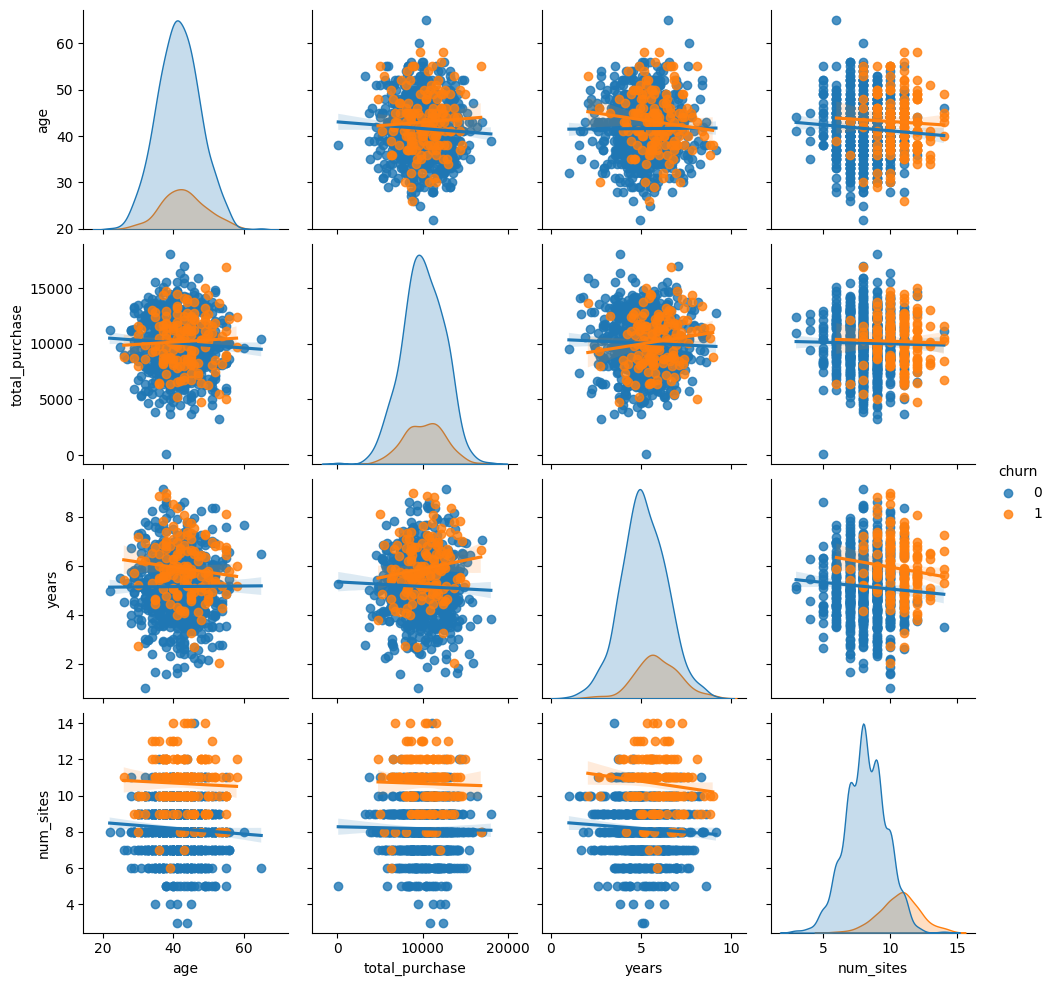

In [20]:
sns.pairplot(kor_data, vars = ["age", "total_purchase","years","num_sites"], 
             hue = "churn",
            kind = "reg");

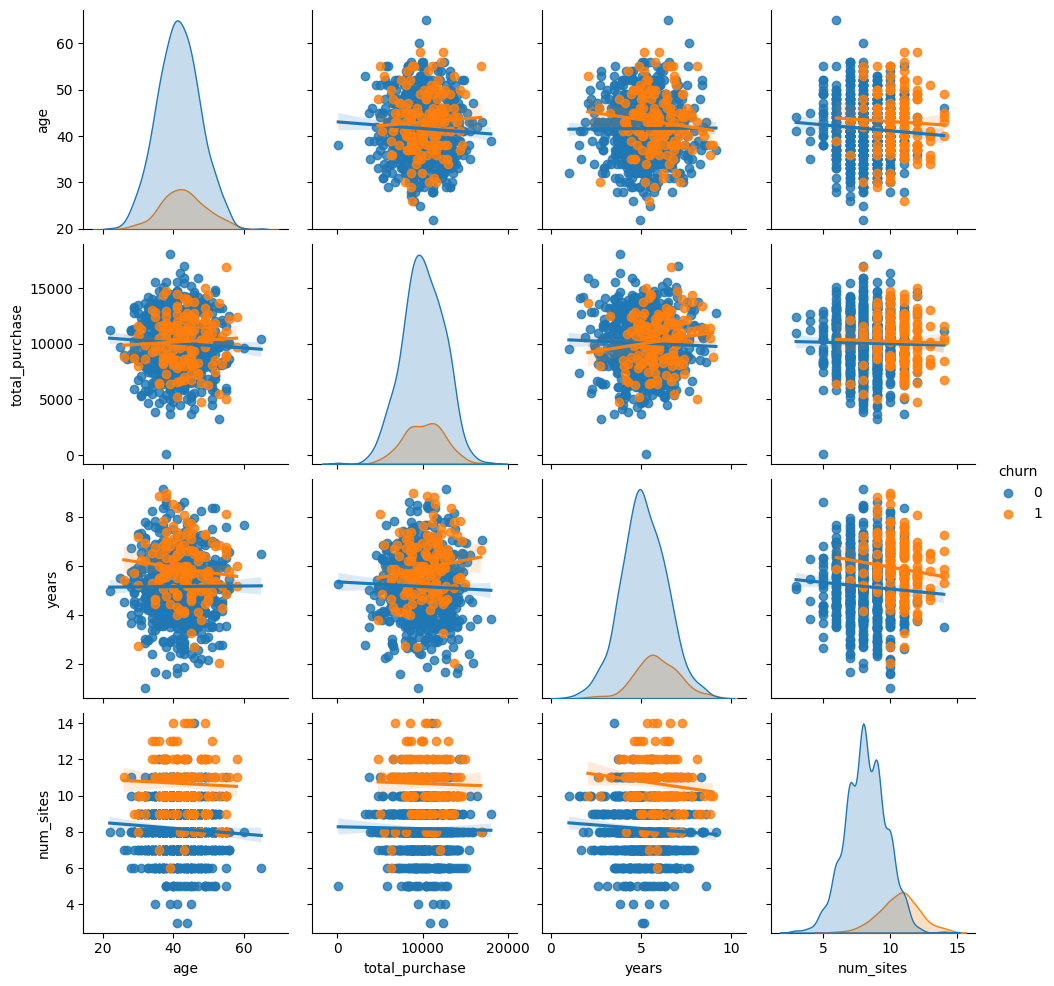

In [21]:
sns.pairplot(kor_data, vars = ["age", "total_purchase","years","num_sites"], 
             hue = "churn",
            kind = "reg");

## Data preprocessing

In [22]:
spark_df = spark_df.dropna()

In [24]:
spark_df.show(5)

+-----+----------------+----+--------------+---------------+-----+---------+-----+
|index|           names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
|    2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|
|    3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|
|    4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 5 rows



In [27]:
from pyspark.ml.feature import StringIndexer

string_ındexer = StringIndexer(inputCol = "churn", outputCol = "label")

In [28]:
# ?string_ındexer

In [29]:
indexed = string_ındexer.fit(spark_df).transform(spark_df)

In [32]:
indexed.show(5)

+-----+----------------+----+--------------+---------------+-----+---------+-----+-----+
|index|           names| age|total_purchase|account_manager|years|num_sites|churn|label|
+-----+----------------+----+--------------+---------------+-----+---------+-----+-----+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|  1.0|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|  1.0|
|    2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|  1.0|
|    3|   Phillip White|42.0|       8010.76|              0| 6.71|     10.0|    1|  1.0|
|    4|  Cynthia Norton|37.0|       9191.58|              0| 5.56|      9.0|    1|  1.0|
+-----+----------------+----+--------------+---------------+-----+---------+-----+-----+
only showing top 5 rows



In [33]:
indexed.dtypes

[('index', 'int'),
 ('names', 'string'),
 ('age', 'double'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'double'),
 ('churn', 'int'),
 ('label', 'double')]

In [34]:
indexed_spark_df = indexed.withColumn("label", indexed["label"].cast("integer"))

In [35]:
indexed_spark_df.dtypes

[('index', 'int'),
 ('names', 'string'),
 ('age', 'double'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'double'),
 ('churn', 'int'),
 ('label', 'int')]

In [41]:
indexed_spark_df.select("churn","label").show(5)

+-----+-----+
|churn|label|
+-----+-----+
|    1|    1|
|    1|    1|
|    1|    1|
|    1|    1|
|    1|    1|
+-----+-----+
only showing top 5 rows



In [42]:
#adjustment of independent variables

In [43]:
from pyspark.ml.feature import VectorAssembler

In [44]:
indexed_spark_df.columns

['index',
 'names',
 'age',
 'total_purchase',
 'account_manager',
 'years',
 'num_sites',
 'churn',
 'label']

In [45]:
independents = ["age","total_purchase", "account_manager","years","num_sites"]

In [46]:
vector_assembler = VectorAssembler(inputCols = independents, outputCol = "features")

In [53]:
va_df = vector_assembler.transform(indexed_spark_df)

In [54]:
va_df.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|[42.0,11066.8,0.0...|
|[41.0,11916.22,0....|
|[38.0,12884.75,0....|
|[42.0,8010.76,0.0...|
|[37.0,9191.58,0.0...|
+--------------------+
only showing top 5 rows



In [55]:
va_df.select("label").show(5)

+-----+
|label|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 5 rows



In [56]:
final_df = va_df.select(["features","label"])

In [57]:
final_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
|[42.0,8010.76,0.0...|    1|
|[37.0,9191.58,0.0...|    1|
+--------------------+-----+
only showing top 5 rows

